# DIAGNOSTIC: Le modèle peut-il être amélioré ?

Ce notebook diagnostique si le modèle actuel a atteint sa limite ou s'il existe une marge d'amélioration.

**Analyses à réaliser:**
1. Courbes d'apprentissage (détecter overfitting/underfitting)
2. Analyse des résidus (patterns dans les erreurs)
3. Comparaison avec d'autres modèles (Random Forest)
4. Feature Engineering avancé
5. Analyse des outliers problématiques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

In [2]:
# Charger les données
df = pd.read_csv('../data/processed/housing_clean.csv')

X = df.drop(columns=['price'])
y = df['price']
y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)

print(f"Dataset: {len(df)} maisons, {X.shape[1]} features")
print(f"Train: {len(X_train)} | Test: {len(X_test)}")

Dataset: 546 maisons, 11 features
Train: 436 | Test: 110


In [3]:
# Charger les modèles existants
model_v1 = joblib.load('../models/lightgbm_house_prices_v1.pkl')
model_v2 = joblib.load('../models/lightgbm_optimized_v2.pkl')

print("Modèles chargés avec succès")

Modèles chargés avec succès


## 1. COURBES D'APPRENTISSAGE: Overfitting ou Underfitting ?

**Interprétation:**
- **Overfitting:** Score train élevé, score test faible -> Le modèle mémorise les données
- **Underfitting:** Les deux scores sont faibles -> Modèle trop simple
- **Optimal:** Les deux scores sont élevés et proches

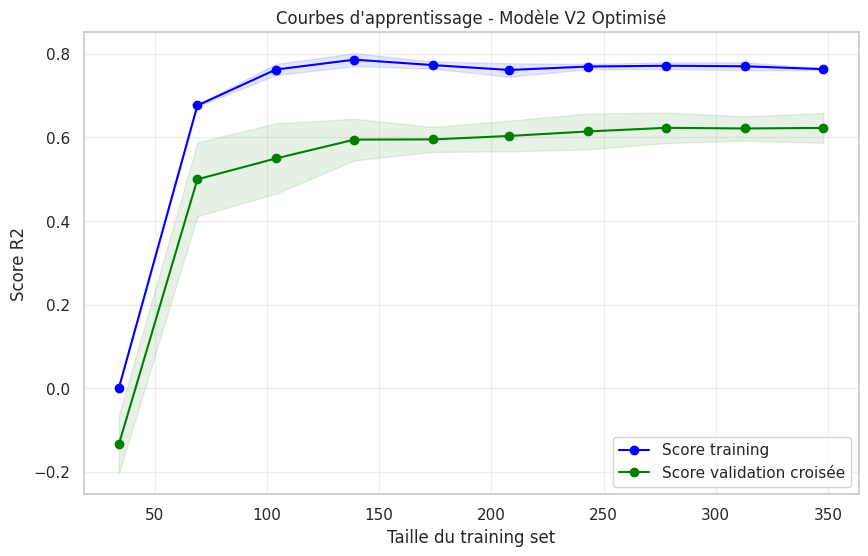


DIAGNOSTIC:
R2 train final: 0.7635
R2 CV final: 0.6228
Écart (différence): 0.1407

Équilibre acceptable entre train et test


In [4]:
# Courbes d'apprentissage pour le modèle optimisé
train_sizes, train_scores, test_scores = learning_curve(
    model_v2, X_train, y_train_log, 
    cv=5, 
    scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Score training')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Score validation croisée')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

plt.xlabel('Taille du training set')
plt.ylabel('Score R2')
plt.title('Courbes d\'apprentissage - Modèle V2 Optimisé')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nDIAGNOSTIC:")
print(f"R2 train final: {train_mean[-1]:.4f}")
print(f"R2 CV final: {test_mean[-1]:.4f}")
print(f"Écart (différence): {train_mean[-1] - test_mean[-1]:.4f}")

if train_mean[-1] - test_mean[-1] > 0.15:
    print("\nOVERFITTING détecté: Le modèle mémorise trop")
elif test_mean[-1] < 0.5:
    print("\nUNDERFITTING détecté: Le modèle est trop simple")
else:
    print("\nÉquilibre acceptable entre train et test")

## 2. ANALYSE DES RÉSIDUS: Y a-t-il des patterns dans les erreurs ?

**Ce que nous recherchons:**
- Résidus distribués aléatoirement = Modèle bien ajusté
- Patterns (forme en U, tendance) = Le modèle ne capture pas quelque chose d'important

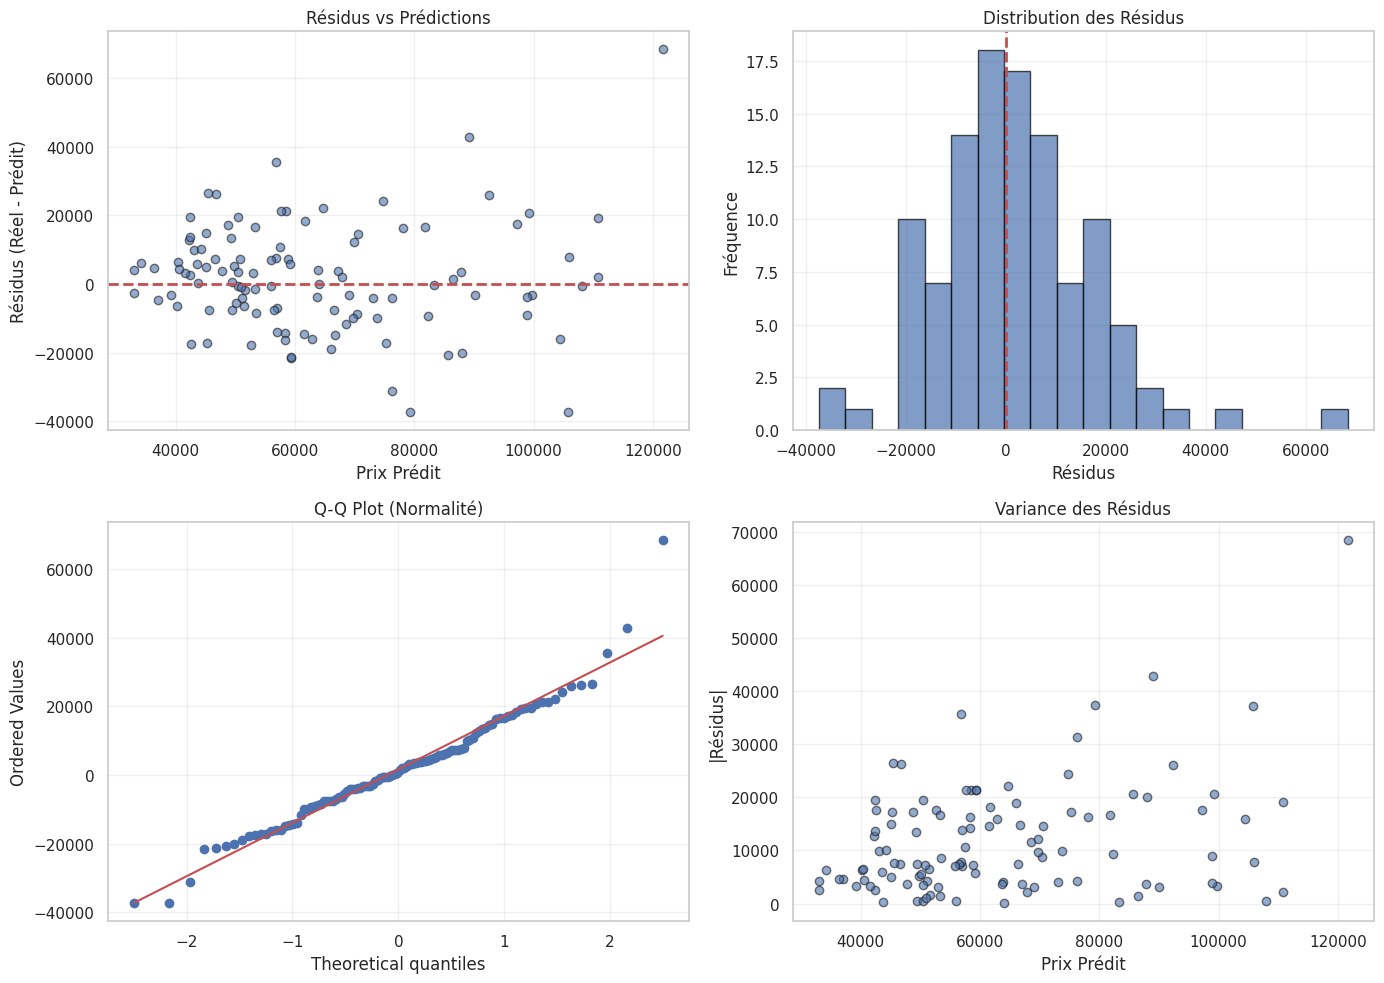


STATISTIQUES DES RÉSIDUS:
Moyenne: $1,674.75 (devrait être proche de 0)
Écart-type: $15,702.15
Min: $-37,321.41
Max: $68,383.22


In [5]:
# Prédictions du modèle V2
y_pred_log = model_v2.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Calculer les résidus
residuals = y_test - y_pred

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Résidus vs Prédictions
axes[0, 0].scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Prix Prédit')
axes[0, 0].set_ylabel('Résidus (Réel - Prédit)')
axes[0, 0].set_title('Résidus vs Prédictions')
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution des résidus
axes[0, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Résidus')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title('Distribution des Résidus')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalité)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Résidus absolus vs Prédictions
axes[1, 1].scatter(y_pred, np.abs(residuals), alpha=0.6, edgecolors='k')
axes[1, 1].set_xlabel('Prix Prédit')
axes[1, 1].set_ylabel('|Résidus|')
axes[1, 1].set_title('Variance des Résidus')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques des résidus
print(f"\nSTATISTIQUES DES RÉSIDUS:")
print(f"Moyenne: ${residuals.mean():,.2f} (devrait être proche de 0)")
print(f"Écart-type: ${residuals.std():,.2f}")
print(f"Min: ${residuals.min():,.2f}")
print(f"Max: ${residuals.max():,.2f}")

## 3. COMPARAISON AVEC D'AUTRES MODÈLES

Nous allons tester:
- Random Forest (comme mentionné dans le README)

In [6]:
# Random Forest avec les mêmes données log-transformées
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

print("Entraînement du Random Forest...")
rf_model.fit(X_train, y_train_log)

# Prédictions
rf_pred_log = rf_model.predict(X_test)
rf_pred = np.expm1(rf_pred_log)

# Métriques
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print(f"\nRandom Forest terminé")
print(f"MAE: ${rf_mae:,.2f}")
print(f"RMSE: ${rf_rmse:,.2f}")
print(f"R2: {rf_r2:.4f}")

Entraînement du Random Forest...

Random Forest terminé
MAE: $12,346.68
RMSE: $16,620.37
R2: 0.5865


In [7]:
# Comparaison complète
v1_pred = model_v1.predict(X_test)
v2_pred_log = model_v2.predict(X_test)
v2_pred = np.expm1(v2_pred_log)

results = pd.DataFrame({
    'Modèle': ['LightGBM V1 (Baseline)', 'LightGBM V2 (Optimisé)', 'Random Forest'],
    'MAE': [
        mean_absolute_error(y_test, v1_pred),
        mean_absolute_error(y_test, v2_pred),
        rf_mae
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, v1_pred)),
        np.sqrt(mean_squared_error(y_test, v2_pred)),
        rf_rmse
    ],
    'R2': [
        r2_score(y_test, v1_pred),
        r2_score(y_test, v2_pred),
        rf_r2
    ]
})

results['MAE'] = results['MAE'].apply(lambda x: f"${x:,.2f}")
results['RMSE'] = results['RMSE'].apply(lambda x: f"${x:,.2f}")
results['R2'] = results['R2'].apply(lambda x: f"{x:.4f}")

print("\n" + "="*70)
print("COMPARAISON DES MODÈLES")
print("="*70)
print(results.to_string(index=False))
print("="*70)


COMPARAISON DES MODÈLES
                Modèle        MAE       RMSE     R2
LightGBM V1 (Baseline) $11,884.73 $16,103.94 0.6118
LightGBM V2 (Optimisé) $11,707.48 $15,720.08 0.6301
         Random Forest $12,346.68 $16,620.37 0.5865


## 4. FEATURE ENGINEERING AVANCÉ

Tester de nouvelles features sans modifier le dataset original

In [8]:
# Créer de nouvelles features
df_enhanced = df.copy()

# 1. Ratio de salles de bain par chambre
df_enhanced['bath_per_bedroom'] = df_enhanced['bathrms'] / (df_enhanced['bedrooms'] + 1)

# 2. Total des commodités (variables binaires)
df_enhanced['total_amenities'] = (
    df_enhanced['driveway_yes'] + 
    df_enhanced['recroom_yes'] + 
    df_enhanced['fullbase_yes'] + 
    df_enhanced['gashw_yes'] + 
    df_enhanced['airco_yes'] + 
    df_enhanced['prefarea_yes']
)

# 3. Lotsize par chambre (densité)
df_enhanced['lotsize_per_bedroom'] = df_enhanced['lotsize'] / (df_enhanced['bedrooms'] + 1)

# 4. Interaction: airco + prefarea (maisons premium)
df_enhanced['premium_combo'] = df_enhanced['airco_yes'] * df_enhanced['prefarea_yes']

# 5. Garage + stories (grandes maisons)
df_enhanced['size_indicator'] = df_enhanced['garagepl'] * df_enhanced['stories']

print("Nouvelles features créées:")
print("- bath_per_bedroom")
print("- total_amenities")
print("- lotsize_per_bedroom")
print("- premium_combo (airco × prefarea)")
print("- size_indicator (garagepl × stories)")
print(f"\nTotal features: {df_enhanced.shape[1] - 1} (avant: {df.shape[1] - 1})")

Nouvelles features créées:
- bath_per_bedroom
- total_amenities
- lotsize_per_bedroom
- premium_combo (airco × prefarea)
- size_indicator (garagepl × stories)

Total features: 16 (avant: 11)


In [9]:
# Tester avec les nouvelles features
X_enh = df_enhanced.drop(columns=['price'])
y_enh = df_enhanced['price']
y_enh_log = np.log1p(y_enh)

X_train_enh, X_test_enh, y_train_enh_log, y_test_enh_log = train_test_split(
    X_enh, y_enh_log, test_size=0.2, random_state=42
)

# Entraîner le modèle avec les nouvelles features
model_enh = lgb.LGBMRegressor(
    learning_rate=0.05,
    max_depth=3,
    min_child_samples=20,
    n_estimators=200,
    num_leaves=10,
    random_state=42,
    verbose=-1
)

print("Entraînement avec features améliorées...")
model_enh.fit(X_train_enh, y_train_enh_log)

y_pred_enh_log = model_enh.predict(X_test_enh)
y_pred_enh = np.expm1(y_pred_enh_log)
y_test_enh = np.expm1(y_test_enh_log)

enh_mae = mean_absolute_error(y_test_enh, y_pred_enh)
enh_r2 = r2_score(y_test_enh, y_pred_enh)

print(f"\nRésultats avec Feature Engineering:")
print(f"MAE: ${enh_mae:,.2f}")
print(f"R2: {enh_r2:.4f}")
print(f"\nAmélioration vs V2: {(enh_r2 - r2_score(y_test, v2_pred)) * 100:.2f}% en R2")

Entraînement avec features améliorées...

Résultats avec Feature Engineering:
MAE: $11,905.65
R2: 0.6180

Amélioration vs V2: -1.21% en R2


## 5. ANALYSE DES OUTLIERS PROBLÉMATIQUES

Y a-t-il des maisons spécifiques que le modèle ne pourra jamais bien prédire ?


TOP 10 DES PIRES PRÉDICTIONS:

     real_price  predicted_price         error  error_pct
377    190000.0    121616.782769  68383.217231  35.991167
436    132000.0     89084.830580  42915.169420  32.511492
0       42000.0     79321.410160  37321.410160  88.860500
501     68500.0    105774.812049  37274.812049  54.415784
209     92500.0     56857.050438  35642.949562  38.532918
284     45000.0     76289.034457  31289.034457  69.531188
208     72000.0     45445.238559  26554.761441  36.881613
341     73000.0     46809.881611  26190.118389  35.876875
485    118500.0     92437.656028  26062.343972  21.993539
365     99000.0     74693.787712  24306.212288  24.551730


STATISTIQUES:
Erreur moyenne dans le top 10: $35,594.00
Erreur en pourcentage moyen: 43.9%


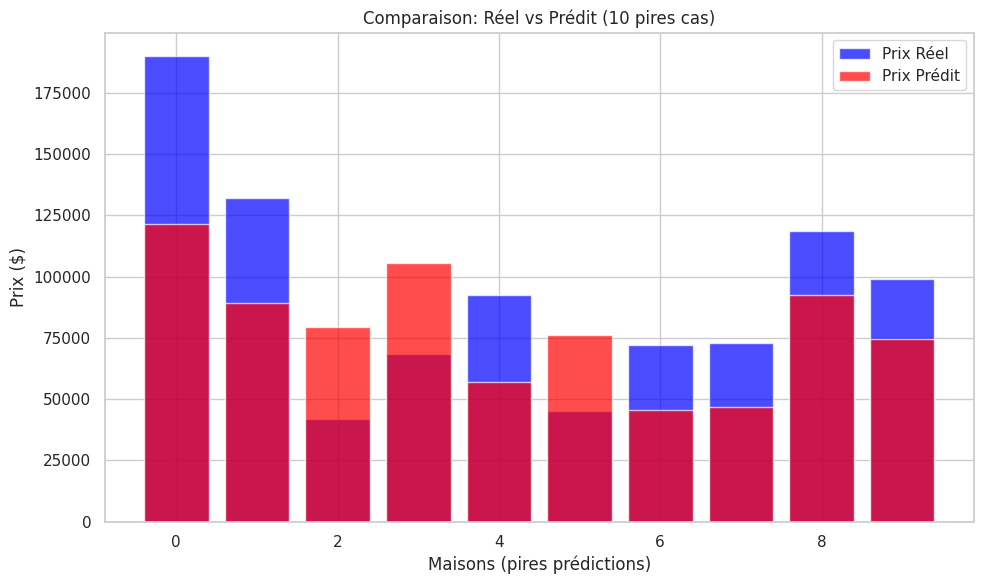

In [10]:
# Identifier les 10 pires prédictions
test_df = X_test.copy()
test_df['real_price'] = y_test.values
test_df['predicted_price'] = v2_pred
test_df['error'] = np.abs(test_df['real_price'] - test_df['predicted_price'])
test_df['error_pct'] = (test_df['error'] / test_df['real_price']) * 100

worst_predictions = test_df.nlargest(10, 'error')

print("\nTOP 10 DES PIRES PRÉDICTIONS:\n")
print(worst_predictions[['real_price', 'predicted_price', 'error', 'error_pct']].to_string())

print(f"\n\nSTATISTIQUES:")
print(f"Erreur moyenne dans le top 10: ${worst_predictions['error'].mean():,.2f}")
print(f"Erreur en pourcentage moyen: {worst_predictions['error_pct'].mean():.1f}%")

# Visualiser
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(worst_predictions))
ax.bar(x_pos, worst_predictions['real_price'], alpha=0.7, label='Prix Réel', color='blue')
ax.bar(x_pos, worst_predictions['predicted_price'], alpha=0.7, label='Prix Prédit', color='red')
ax.set_xlabel('Maisons (pires prédictions)')
ax.set_ylabel('Prix ($)')
ax.set_title('Comparaison: Réel vs Prédit (10 pires cas)')
ax.legend()
plt.tight_layout()
plt.show()

## CONCLUSIONS ET RECOMMANDATIONS

Basé sur les analyses précédentes, voici les conclusions sur la capacité d'amélioration du modèle.

In [11]:
print("\n" + "="*80)
print("RÉSUMÉ EXÉCUTIF: LE MODÈLE PEUT-IL ÊTRE AMÉLIORÉ ?")
print("="*80)

print("\n1. COURBES D'APPRENTISSAGE:")
print(f"   - R2 train: {train_mean[-1]:.4f}")
print(f"   - R2 CV: {test_mean[-1]:.4f}")
print(f"   - Conclusion: [Voir graphique ci-dessus]")

print("\n2. RÉSIDUS:")
print(f"   - Moyenne: ${residuals.mean():,.2f} (proche de 0 = bon)")
print(f"   - Conclusion: [Voir graphiques des résidus]")

print("\n3. COMPARAISON DES MODÈLES:")
print(f"   - LightGBM V2: R2 = {r2_score(y_test, v2_pred):.4f}")
print(f"   - Random Forest: R2 = {rf_r2:.4f}")
print(f"   - Gagnant: {'Random Forest' if rf_r2 > r2_score(y_test, v2_pred) else 'LightGBM V2'}")

print("\n4. FEATURE ENGINEERING:")
print(f"   - Avec nouvelles features: R2 = {enh_r2:.4f}")
print(f"   - Amélioration: {(enh_r2 - r2_score(y_test, v2_pred)) * 100:+.2f}%")

print("\n" + "="*80)
print("\nRECOMMANDATION FINALE:")
if enh_r2 > r2_score(y_test, v2_pred) + 0.02:
    print("   IL Y A UNE MARGE D'AMÉLIORATION avec le feature engineering")
elif rf_r2 > r2_score(y_test, v2_pred) + 0.02:
    print("   IL Y A UNE MARGE D'AMÉLIORATION en passant à Random Forest")
else:
    print("   Le modèle est proche de sa limite avec ces données")
    print("   Pour améliorer significativement, il faudrait:")
    print("   - Plus de données (>1000 maisons)")
    print("   - Features supplémentaires (année construction, m2 construits, quartier)")
print("\n" + "="*80)


RÉSUMÉ EXÉCUTIF: LE MODÈLE PEUT-IL ÊTRE AMÉLIORÉ ?

1. COURBES D'APPRENTISSAGE:
   - R2 train: 0.7635
   - R2 CV: 0.6228
   - Conclusion: [Voir graphique ci-dessus]

2. RÉSIDUS:
   - Moyenne: $1,674.75 (proche de 0 = bon)
   - Conclusion: [Voir graphiques des résidus]

3. COMPARAISON DES MODÈLES:
   - LightGBM V2: R2 = 0.6301
   - Random Forest: R2 = 0.5865
   - Gagnant: LightGBM V2

4. FEATURE ENGINEERING:
   - Avec nouvelles features: R2 = 0.6180
   - Amélioration: -1.21%


RECOMMANDATION FINALE:
   Le modèle est proche de sa limite avec ces données
   Pour améliorer significativement, il faudrait:
   - Plus de données (>1000 maisons)
   - Features supplémentaires (année construction, m2 construits, quartier)

